In [34]:
import numpy as np
import pandas as pd
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [35]:
pd.set_option('display.max_columns',None)

In [36]:
df = pd.read_csv('zillow_data copy.csv')
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,329121.0,334059.0,338019.0,346657.0,354457.0,361917.0,369769.0,376112.0,381673.0,386586.0,394154.0,402687.0,412006.0,420541.0,429242.0,436291.0,442139.0,447655.0,452725.0,457455.0,461020.0,465658.0,469811.0,475268.0,478912.0,482464.0,484481.0,488259.0,493127.0,499165.0,503717.0,507932.0,511068.0,514280.0,518252.0,522487.0,527352.0,531284.0,535317.0,539349.0,549450.0,567133.0,588505.0,605851.0,613242.0,617110.0,619549.0,625388.0,631255.0,636089.0,639742.0,643306.0,647193.0,652314.0,659961.0,669842.0,683972.0,696806.0,708743.0,716797.0,728843.0,739511.0,759399.0,771571.0,785979.0,795559.0,805064.0,814587.0,817033.0,832764.0,850933.0,876511.0,901911.0,921178.0,927869.0,922251.0,924475.0,931610.0,934145.0,909286.0,874103.0,840213.0,841253.0,864029.0,878088.0,880955.0,875206.0,881249.0,884836.0,877242.0,872894.0,865069.0,888219.0,909058.0,932691.0,932638.0,933780.0,929386.0,935242.0,949011.0,950769.0,940471.0,901618.0,887671.0,894583.0,898397.0,891086.0,854973.0,823871.0,7

In [37]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[9:], format='%Y-%m')

In [38]:
df.columns = list(df.columns[:9]) + list(get_datetimes(df))

In [39]:
#Only rows within the top states of the northeast US
df = df[df['State'].isin(['NY', 'PA', 'NJ', 'MA', 'CT'])]
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,2000-09-30 00:00:00,2000-10-31 00:00:00,2000-11-30 00:00:00,2000-12-31 00:00:00,2001-01-31 00:00:00,2001-02-28 00:00:00,2001-03-31 00:00:00,2001-04-30 00:00:00,2001-05-31 00:00:00,2001-06-30 00:00:00,2001-07-31 00:00:00,2001-08-31 00:00:00,2001-09-30 00:00:00,2001-10-31 00:00:00,2001-11-30 00:00:00,2001-12-31 00:00:00,2002-01-31 00:00:00,2002-02-28 00:00:00,2002-03-31 00:00:00,2002-04-30 00:00:00,2002-05-31 00:00:00,2002-06-30 00:00:00,2002-07-31 00:00:00,2002-08-31 00:00:00,2002-09-30 00:00:00,2002-10-31 00:00:00,2002-11-30 00:00:00,2002-12-31 00:00:00,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,2003-10-31 00:00:00,2003-11-30 00:00:00,2003-12-31 00:00:00,2004-01-31 00:00:00,2004-02-29 00:00:00,2004-03-31 00:00:00,2004-04-30 00:00:00,2004-05-31 00:00:00,2004-06-30 00:00:00,2004-07-31 00:00:00,2004-08-31 00:00:00,2004-09-30 00:00:00,2004-10-31 00:00:00,2004-11-30 00:00:00,2004-12-31 00:00:00,2005-01-31 00:00:00,2005-02-28 00:00:00,2005-03-31 00:00:00,2005-04-30 00:00:00,2005-05-31 00:00:00,2005-06-30 00:00:00,2005-07-31 00:00:00,2005-08-31 00:00:00,2005-09-30 00:00:00,2005-10-31 00:00:00,2005-11-30 00:00:00,2005-12-31 00:00:00,2006-01-31 00:00:00,2006-02-28 00:00:00,2006-03-31 00:00:00,2006-04-30 00:00:00,2006-05-31 00:00:00,2006-06-30 00:00:00,2006-07-31 00:00:00,2006-08-31 00:00:00,2006-09-30 00:00:00,2006-10-31 00:00:00,2006-11-30 00:00:00,2006-12-31 00:00:00,2007-01-31 00:00:00,2007-02-28 00:00:00,2007-03-31 00:00:00,2007-04-30 00:00:00,2007-05-31 00:00:00,2007-06-30 00:00:00,2007-07-31 00:00:00,2007-08-31 00:00:00,2007-09-30 00:00:00,2007-10-31 00:00:00,2007-11-30 00:00:00,2007-12-31 00:00:00,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,2008-10-31 00:00:00,2008-11-30 00:00:00,2008-12-31 00:00:00,2009-01-31 00:00:00,2009-02-28 00:00:00,2009-03-31 00:00:00,2009-04-30 00:00:00,2009-05-31 00:00:00,2009-06-30 00:00:00,2009-07-31 00:00:00,2009-08-31 00:00:00,2009-09-30 00:00:00,2009-10-31 00:00:00,2009-11-30 00:00:00,2009-12-31 00:00:00,2010-01-31 00:00:00,2010-02-28 00:00:00,2010-03-31 00:00:00,2010-04-30 00:00:00,2010-05-31 00:00:00,2010-06-30 00:00:00,2010-07-31 00:00:00,2010-08-31 00:00:00,2010-09-30 00:00:00,2010-10-31 00:00:00,2010-11-30 00:00:00,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00,2011-12-31 00:00:00,2012-01-31 00:00:00,2012-02-29 00:00:00,2012-03-31 00:00:00,2012-04-30 00:00:00,2012-05-31 00:00:00,2012-06-30 00:00:00,2012-07-31 00:00:00,2012-08-31 00:00:00,2012-09-30 00:00:00,2012-10-31 00:00:00,2012-11-30 00:00:00,2012-12-31 00:00:00,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00,2013-09-30 00:00:00,2013-10-31 00:00:00,2013-11-30 00:00:00,2013-12-31 00:00:00,2014-01-31 00:00:00,2014-02-28 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,2014-05-31 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-10-31 00:00:00,2014-11-30 00:00:00,2014-12-31 00:00:00,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,2015-07-31 00:00:00,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00,2015-11-30 00:00:00,2015-12-31 00:00:00,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2

In [40]:
#grouping the columns by years and their average price
c = df.columns.tolist()
cols = c[:9] 
cols.append(c[-1]) 
print (cols)

#set to index all NOT date columns
tdf = df.set_index(df.columns.tolist()[:9])
tdf.columns = pd.to_datetime(tdf.columns).to_period('M')

# find the columns in the period 2000-2021
cols = tdf.columns
sel_cols = cols[(cols > '2000-01') & (cols < '2022')]
print (sel_cols)


#change format columns
a = tdf[sel_cols].rename(columns=lambda x: '{:}'.format(x.year, [1]))
print (a.columns)

#groupby by a with new format
mdf = a.groupby(a.columns, axis=1).mean().reset_index()

['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', Timestamp('2021-08-31 00:00:00')]
PeriodIndex(['2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
             '2000-08', '2000-09', '2000-10', '2000-11',
             ...
             '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
             '2021-05', '2021-06', '2021-07', '2021-08'],
            dtype='period[M]', length=259, freq='M')
Index(['2000', '2000', '2000', '2000', '2000', '2000', '2000', '2000', '2000',
       '2000',
       ...
       '2020', '2020', '2021', '2021', '2021', '2021', '2021', '2021', '2021',
       '2021'],
      dtype='object', length=259)


In [41]:
mdf['average_annual_return'] = (((mdf['2021']-mdf['2000'])/mdf['2000'])*100)
mdf['rate_year']=mdf['average_annual_return']/21
top_five = mdf.sort_values(by='rate_year', ascending=False).head(5)
top_five

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,average_annual_return,rate_year
2855,58807,16737,2558,Zip,MA,MA,Wareham,Boston-Cambridge-Newton,Plymouth County,36981.818182,46860.750000,58951.166667,73839.583333,81465.333333,91191.083333,98618.500000,90287.416667,90895.416667,81423.500000,81278.916667,81293.000000,84706.583333,109882.416667,136346.750000,1.623931e+05,1.896925e+05,2.189622e+05,2.584022e+05,2.676696e+05,3.246265e+05,366638.625,891.402378,42.447732
92,62027,516,11216,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,159543.000000,186038.166667,220661.500000,268010.916667,313416.416667,377583.333333,460031.750000,522687.083333,541119.583333,471203.166667,456315.666667,465404.083333,507982.166667,613773.833333,814626.583333,9.696168e+05,1.058784e+06,1.076584e+06,1.145235e+06,1.144215e+06,1.145505e+06,1152785.125,622.554499,29.645452
708,65789,5379,19122,Zip,PA,PA,Philadelphia,Philadelphia-Camden-Wilmington,Philadelphia County,43344.909091,49257.500000,60191.916667,73493.833333,92622.500000,107774.916667,136895.916667,160958.416667,155417.500000,164019.416667,167015.916667,158536.416667,145589.583333,161409.416667,167096.083333,1.783024e+05,1.789871e+05,2.031756e+05,2.369558e+05,2.594141e+05,2.750910e+05,295731.375,582.274761,27.727370
227,65788,1572,19121,Zip,PA,PA,Philadelphia,Philadelphia-Camden-Wilmington,Philadelphia County,36210.818182,41512.083333,42839.500000,47378.500000,58035.166667,77900.916667,97453.083333,113018.166667,103451.750000,100302.583333,93118.083333,79137.750000,62845.750000,73558.916667,81038.500000,9.014233e+04,9.106808e+04,1.119107e+05,1.495841e+05,1.782407e+05,2.029722e+05,236809.125,553.973417,26.379687
183,62033,1187,11222,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,179628.636364,222675.416667,298888.750000,360174.833333,421157.666667,573325.750000,654414.833333,663559.750000,641443.416667,582575.250000,563242.000000,573196.083333,618760.000000,737275.833333,876103.333333,1.011760e+06,1.054034e+06,1.063602e+06,1.078892e+06,1.085332e+06,1.087756e+06,1096991.500,510.699676,24.319032


In [42]:
#getting the list of zipcodes
values = set(top_five['RegionID'])
#getting them in our old dateFrame
df_new = df[df['RegionID'].isin([58807, 62027, 62033, 65788, 65789])]

In [43]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [44]:
df_11216 = df_new[df_new['RegionName']==11216]
df_11222 = df_new[df_new['RegionName']==11222]
df_19121 = df_new[df_new['RegionName']==19121]
df_19122 = df_new[df_new['RegionName']==19122]
df_2558  = df_new[df_new['RegionName']==2558]

In [45]:
df_11216 = melt_data(df_11216)
df_11222= melt_data(df_11222)
df_19121= melt_data(df_19121)
df_19122= melt_data(df_19122)
df_2558= melt_data(df_2558)

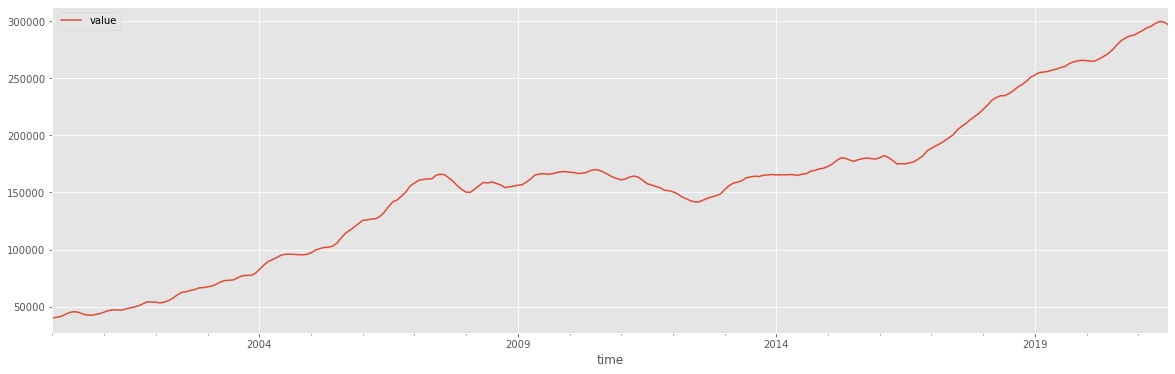

In [46]:
df_19122.plot(figsize=(20,6));

# Baseline Model

In [48]:
naive = df_19122.shift(1)
naive


,value
time,
2000-01-31,NaN
2000-02-29,40085.0
2000-03-31,40648.0
2000-04-30,41501.0
2000-05-31,43180.0
...,...
2021-04-30,294232.0
2021-05-31,295642.0
2021-06-30,298257.0


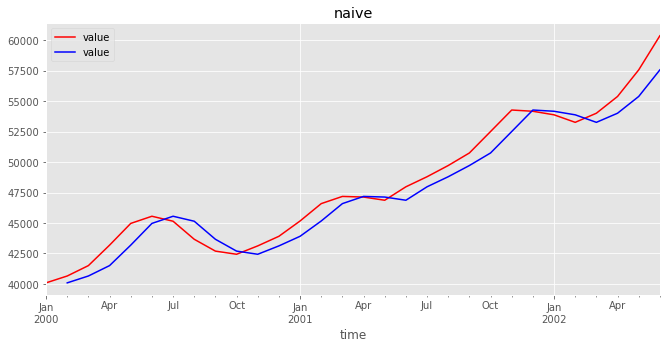

In [50]:
fig, ax = plt.subplots(figsize=(11, 5))

df_19122[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [52]:
dftest = adfuller(naive.dropna())
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.429645
p-value                          0.905030
#Lags Used                      16.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


# Modeling

In [14]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df_19122)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print('19122')
print(dfoutput)

Results of Dickey-Fuller Test: 

19122
Test Statistic                  -0.527167
p-value                          0.886605
#Lags Used                      16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


<AxesSubplot:xlabel='time'>

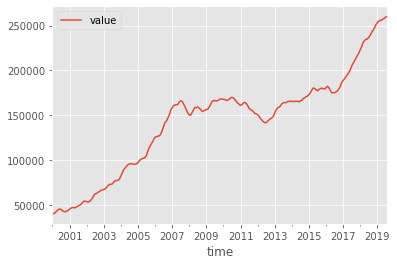

In [15]:
df_19122_train =df_19122[:236]
df_19122_test = df_19122[236:] 
df_19122_train.plot()

# Check Seasonality

We can check for trends, seasonality, and residuals using seasonal_decompose function.


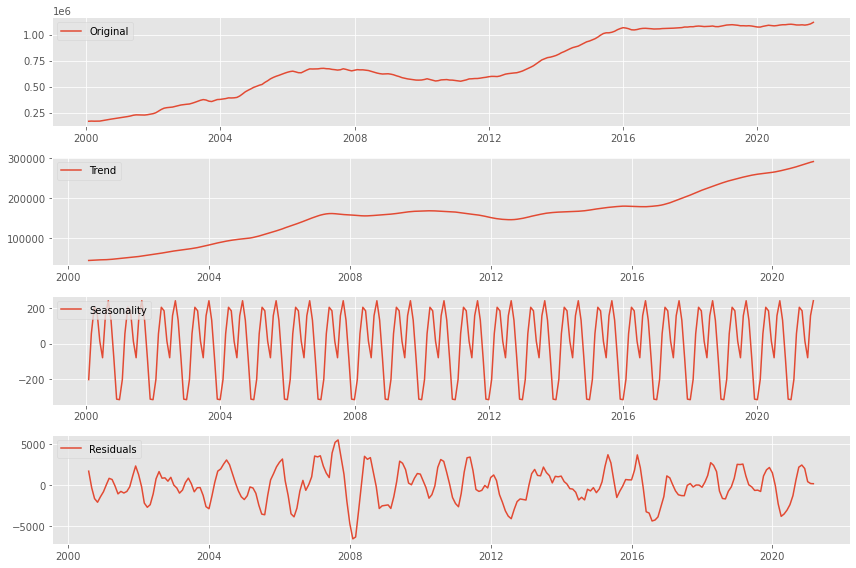

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_19122)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_11222, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

The model has an upward trend with seasonality as well.

# Rolling Mean

<AxesSubplot:xlabel='time'>

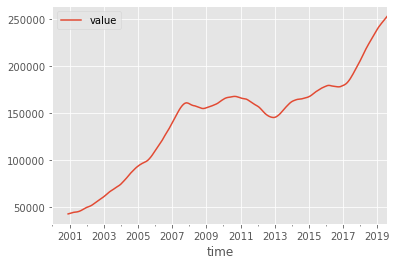

In [16]:
df_19122_train.rolling(12).mean().plot()

# First order difference

<AxesSubplot:xlabel='time'>

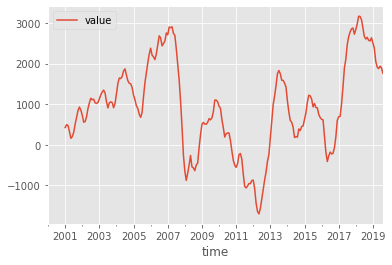

In [17]:
df_19122_train.diff(periods=1).rolling(12).mean().plot()

# Second Order Difference

<AxesSubplot:xlabel='time'>

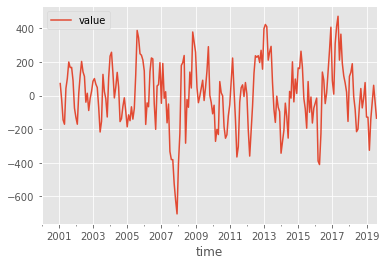

In [18]:
df_19122_train.diff().diff().rolling(12).mean().plot()

# Differencing

In [55]:
diff = df_19122.diff().diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.030660e+00
p-value                        1.420597e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


Taking two difference makes our p-value < 0.05. Let's look at autocorrelation.

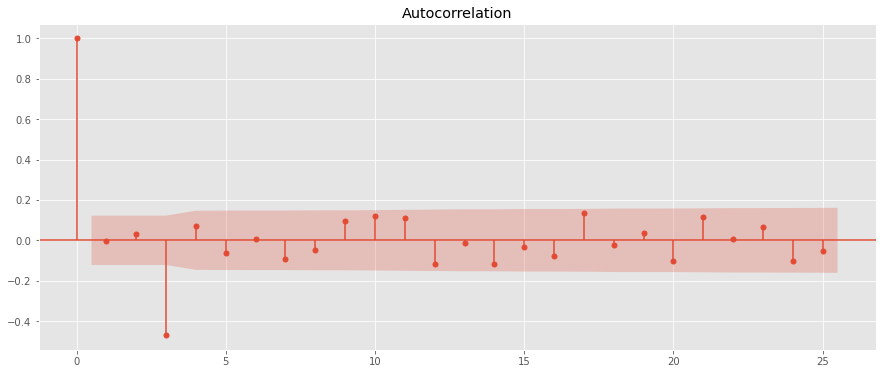

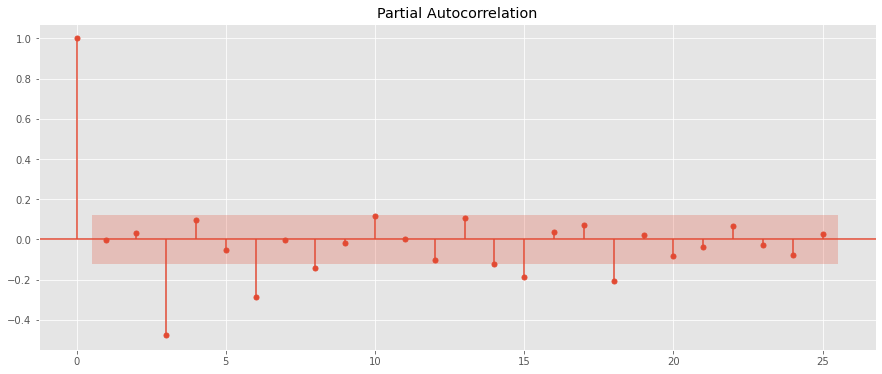

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation Plot
plot_acf(df_19122.diff().diff().dropna());

# Partial Autocorrelation Plot
plot_pacf(df_19122.diff().diff().dropna());

# SARIMAX

In [19]:
# Fit a SARIMAX model on the data set with a first order difference.

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sm = SARIMAX(endog=df_19122_train, order =(0,1,0)).fit()

/Users/avijames/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/avijames/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [21]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(df_19122_train, sm.predict(), squared=False)
rmse

3246.4013087767075

To get the best hyperparameters for our model, we created a combination of orders and seasonal orders in the range of 0-2, inclusive.

In [25]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [26]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_19122,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6974.179626551247
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6502.212039785528
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =6180.005167658495
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5539.6847775767255
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5281.110386950659
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4947.120009652894
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5213.09424233143
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4896.545009156303
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4642.423167125658
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5426.436539986099
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5389.658960706398
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5136.895399352359
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5193.936458341234
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6290.595354810516
ARIMA (0, 0, 0) x (1

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4272.304218552057
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4076.1442124452133
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4168.188089287074
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4092.9993680921607
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3861.7631459807512
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4148.641479888878
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3963.195592139906
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3731.304052076106
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4104.017506260294
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4099.472686910922
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4067.2619507212507
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3928.4480365892027
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3913.9434118109075
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3863.760793069374
ARIMA (0, 1, 1

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =3984.5503613499905
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3937.038843439201
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3856.900790694559
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3849.8395887435913
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3776.0974011768785
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3779.9109431975207
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3699.5994965354266
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3651.54619626443
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4588.79445925495
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4517.999401209763
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4183.321939349123
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4532.703918577967
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4328.633574941592
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4000.9511004543383
ARIMA (1, 0, 0) 

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =3950.1723956470987
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4327.392085762027
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4014.1568342231767
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3781.6734884096604
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4373.20970825684
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3947.3154773384285
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3675.3938620534773
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4162.1546955013655
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4147.475300003205
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =3951.9307197064154
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4073.715694482792
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4016.072199751441
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3775.788952640627
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4061.3385239531594
ARIMA (1, 1, 

ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3893.4320369498478
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4065.9698214137393
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3954.0997628777304
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3724.815913963313
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4087.3422201899043
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3885.1044407946156
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3620.7161303428147
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =3929.7898979643714
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =3925.96382943301
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3896.212042979995
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3819.0783237767937
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3767.2974571761447
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3728.6489921922575
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3735.4841168890644
ARIMA (1, 

ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =3950.7086431377675
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3811.730235197439
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3789.150169155996
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3778.6093205685065
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3740.8097374821555
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3668.297471597455
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3669.941268173963
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4342.289920111973
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4146.24303373466
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =3949.1963841480074
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4323.587258792348
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4015.3311154230414
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3785.665668180329
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4357.655111777542
ARIMA (2, 1, 1) 

ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =3873.0665432792625
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4298.681287469326
ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3931.536611103982
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3717.940521725195
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4316.001689179329
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3927.4283942466736
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3745.296357548712
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4082.8287867759154
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4068.9840370738343
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3878.166708157215
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4040.96245111366
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3930.461864830615
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3734.600991714984
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4064.3313546651484
ARIMA (2, 2, 2) 

In [24]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

NameError: name 'ans' is not defined

From the combination, our SARIMAX model with order=(0,1,2) and seasonal_order=(2, 2, 2, 12) got the lowest aic score.

Now, we can use those hyperparameters for our final model to predict future home values.

In [25]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = SARIMAX(df_19122, 
                                        order=(0, 1, 2), 
                                        seasonal_order=(2, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/Users/avijames/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/avijames/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9758      0.027     36.479      0.000       0.923       1.028
ma.L2          0.9178      0.039     23.791      0.000       0.842       0.993
ar.S.L12       0.0686      0.049      1.387      0.165      -0.028       0.165
ar.S.L24       0.0692      0.036      1.943      0.052      -0.001       0.139
ma.S.L12      -1.6585      0.101    -16.352      0.000      -1.857      -1.460
ma.S.L24       0.6820      0.063     10.833      0.000       0.559       0.805
sigma2      1.333e+06   1.81e+05      7.376      0.000    9.79e+05    1.69e+06


Next, we ran model diagnostics to ensure that none of the assumptions made by the model have been violated.


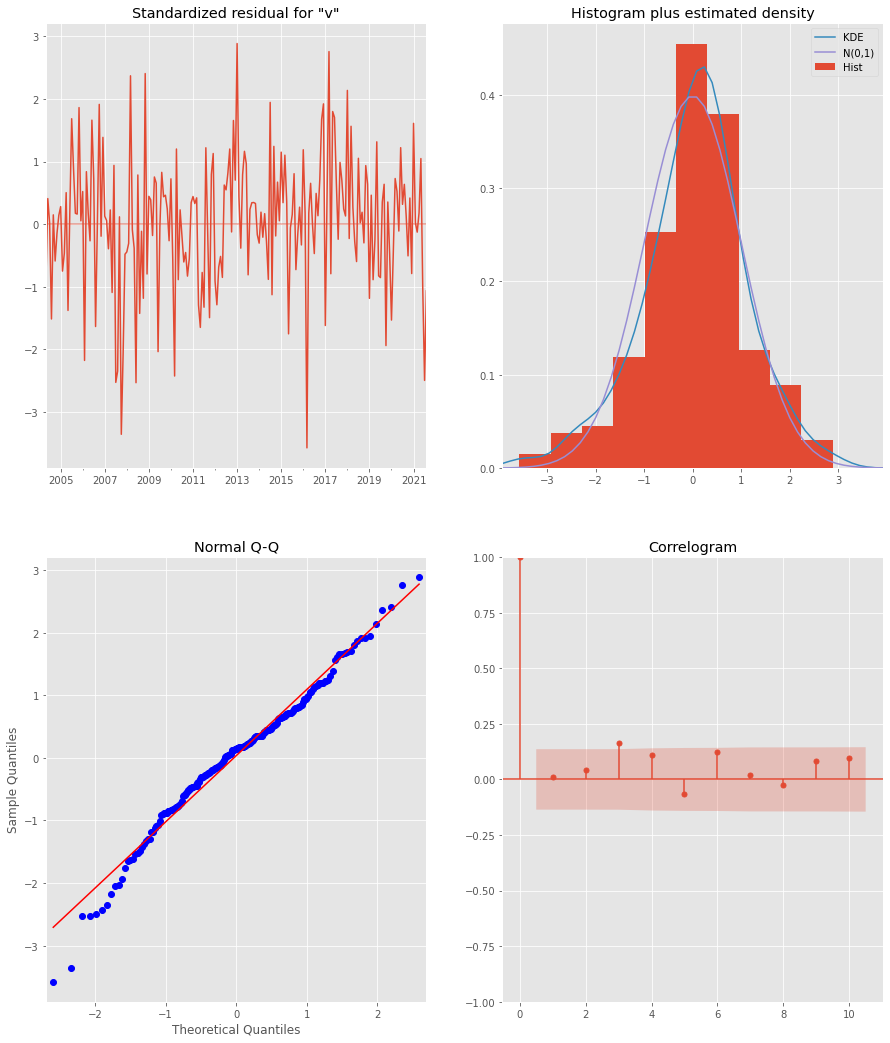

In [26]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The first plot shows that the some residuals are normally distributed. The top right plot shows that the data seems normally distributed. The bottom left plot shows that the residuals follow the linear trend from a standard normal distribution. The bottom right plot shows that the autocorrelation.

# Validating the Model

We will now validate the model by comparing predicted values to real values.

Starting from January 2019

In [27]:
# Get predictions starting from 01-31-2019 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_conf = pred.conf_int()

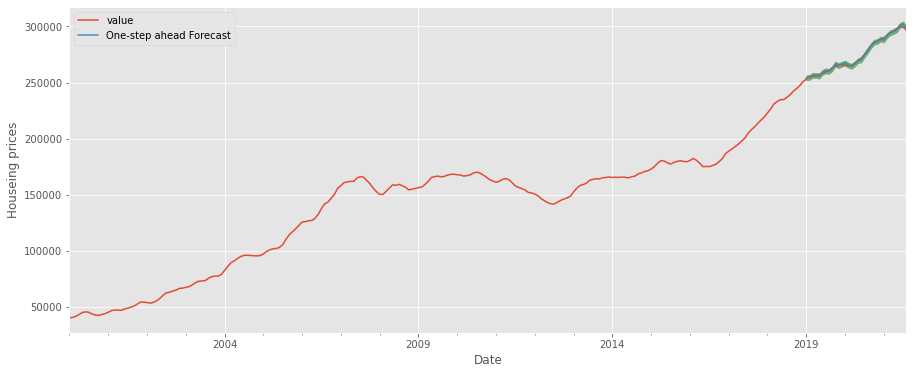

In [28]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_19122.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Houseing prices')
plt.legend()

plt.show()

In [29]:
# Get the real and predicted values
df19122_forecasted = pred.predicted_mean
df19122_truth = df_19122['value']['2019-01-31':]

# Compute the mean square error
mse = ((df19122_forecasted - df19122_truth) ** 2).mean()
rmse =np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 1104.52


# Dynamic Forecasting

In [30]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

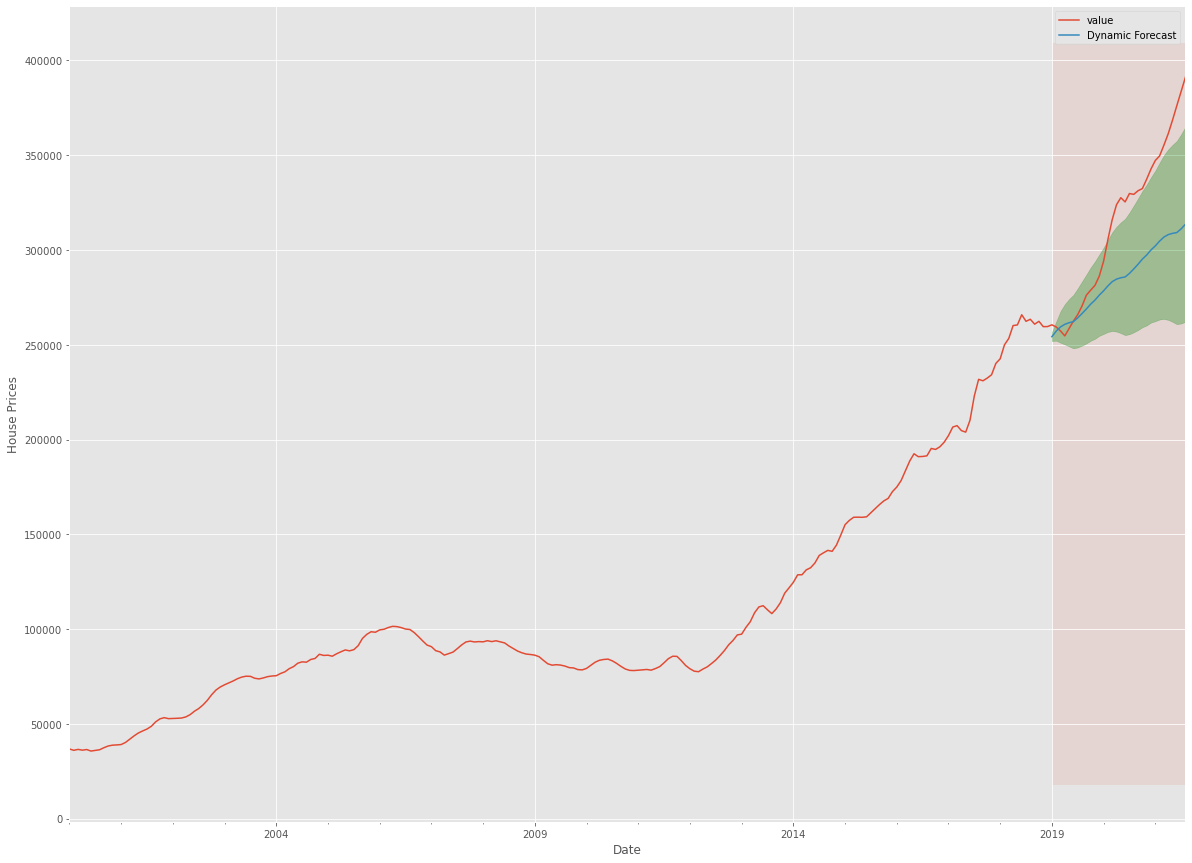

In [31]:
# Plot the dynamic forecast with confidence intervals.

ax = df_2558.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-31'), df19122_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

# Producing and Visualizing Forecasts

In [32]:

# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

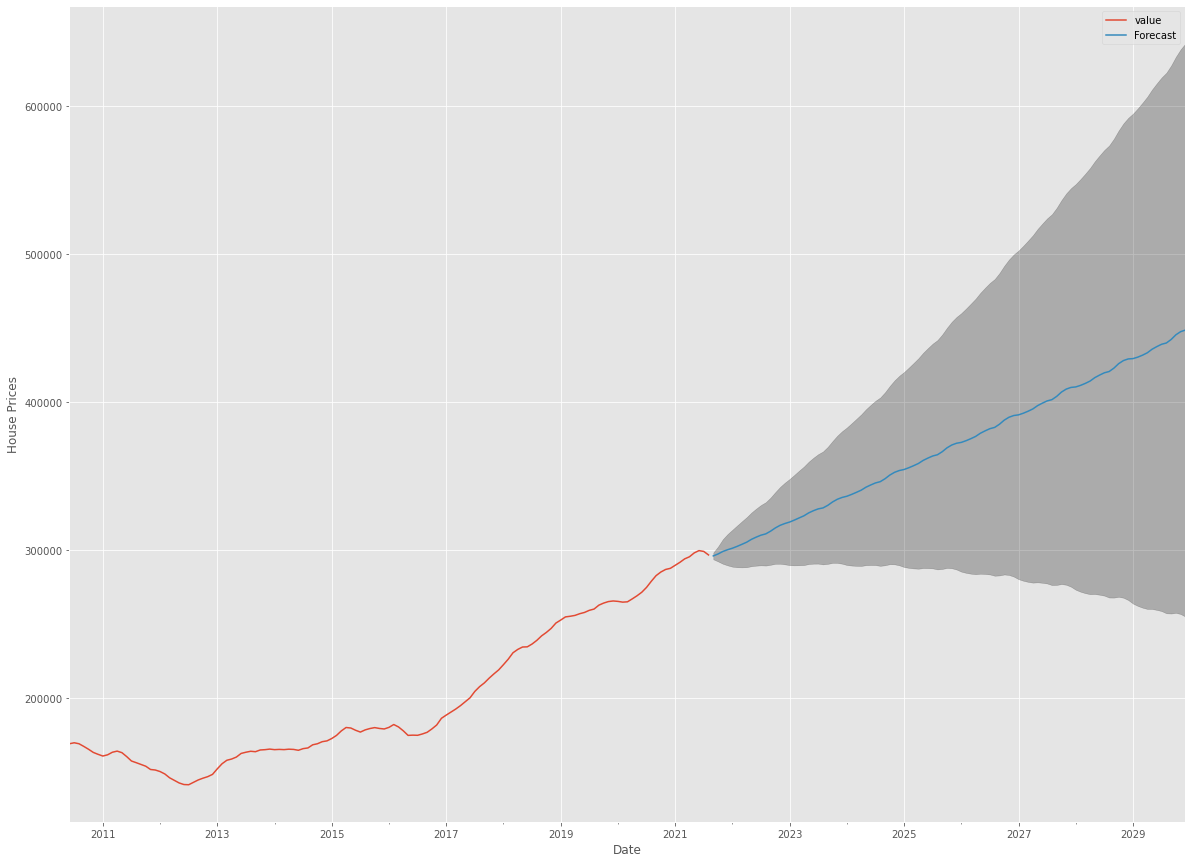

In [33]:
# Plot future predictions with confidence intervals
ax = df_19122.iloc[125:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()